In [3]:
import os
import shutil
import zipfile

def extract_all_zips(root_folder):
    all_folder = os.path.join(root_folder , "_all")
    
    if os.path.exists(all_folder):
        shutil.rmtree(all_folder)

    os.makedirs(all_folder)

    for dirpath, _, filenames in os.walk(root_folder):
        for filename in filenames:
            if filename.endswith('.zip'):
                zip_path = os.path.join(dirpath, filename)
                
                subfolder_name = os.path.splitext(filename)[0]
                extract_dir = os.path.join(all_folder, subfolder_name)
                os.makedirs(extract_dir, exist_ok=True)

                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_dir)
                    print(f"Extracted {zip_path} to {extract_dir}")

In [4]:
base_dir = "/Users/mahdi/Documents/GitHub/snakemake-report-plugin-metadata4ing/examples"
extract_all_zips(base_dir)

Extracted /Users/mahdi/Documents/GitHub/snakemake-report-plugin-metadata4ing/examples/benchmarks/Fenics/ro-crate-metadata-89fc79f6033e6839.zip to /Users/mahdi/Documents/GitHub/snakemake-report-plugin-metadata4ing/examples/_all/ro-crate-metadata-89fc79f6033e6839


In [5]:
from rdflib import Graph

graph_list = []

all_folder = os.path.join(base_dir , "_all")

for root, dirs, files in os.walk(base_dir):
    if 'provenance.jsonld' in files:
        file_path = os.path.join(root, 'provenance.jsonld')
        try:
            g = Graph()
            g.parse(file_path, format='json-ld')
            graph_list.append(g)
            print(f"✅ Parsed: {file_path}")
        except Exception as e:
            print(f"❌ Failed to parse {file_path}: {e}")

print(f"\nTotal graphs loaded: {len(graph_list)}")

✅ Parsed: /Users/mahdi/Documents/GitHub/snakemake-report-plugin-metadata4ing/examples/_all/ro-crate-metadata-89fc79f6033e6839/provenance.jsonld

Total graphs loaded: 1


In [11]:
from tabulate import tabulate

query = """
PREFIX cr: <http://mlcommons.org/croissant/>
PREFIX sio: <http://semanticscience.org/resource/>

SELECT DISTINCT ?value_element_size ?value_young_modulus ?value_poisson_ratio ?value_max_mises_stress
WHERE {
  ?max_mises_stress cr:source/cr:extract [ cr:jsonPath "/max_mises_stress" ] ;
             sio:SIO_000210 [ schema:value ?value_max_mises_stress ] ;
        cr:source/schema:MediaObject ?media_object_max_mises_stress .
   
  ?processing_step schema:result ?media_object_max_mises_stress ;
        schema:object ?media_object_element_size .
  
  ?poisson_ratio cr:source/cr:extract [ cr:jsonPath "/poisson-ratio/value" ] ;
             sio:SIO_000210 [ schema:value ?value_poisson_ratio ] .

  ?young_modulus cr:source/cr:extract [ cr:jsonPath "/young-modulus/value" ] ;
             sio:SIO_000210 [ schema:value ?value_young_modulus ] .

  ?field_size cr:source/cr:extract [ cr:jsonPath "/element-size/value" ] ;
             sio:SIO_000210 [ schema:value ?value_element_size ] ;
        cr:source/schema:MediaObject ?media_object_element_size . 
  
  FILTER EXISTS {
    ?field_degree cr:source/cr:extract [ cr:jsonPath "/element-degree" ] ;
                  sio:SIO_000210 [ schema:value 1 ] ;
        cr:source/schema:MediaObject ?media_object_element_size .          
  }

  FILTER EXISTS {
    ?field_order cr:source/cr:extract [ cr:jsonPath "/element-order" ] ;
                 sio:SIO_000210 [ schema:value 1 ] ;
        cr:source/schema:MediaObject ?media_object_element_size .         
  }
}
"""

table_data = []

headers = [
    "Simulation Hash",
    "element-size",
    "young-modulus",
    "poisson-ratio",
    "max-mises-stress"
]

sort_key = headers.index("element-size")

for g in graph_list:
    local_ns = dict(g.namespace_manager.namespaces()).get("local")
    hash_id = local_ns.strip("/").split("/")[-1] if local_ns else "UNKNOWN"

    results = g.query(query)

    for row in results:
        value_element_size = row.value_element_size
        value_young_modulus = row.value_young_modulus
        value_poisson_ratio = row.value_poisson_ratio
        value_max_mises_stress = row.value_max_mises_stress
        table_data.append(
            [
                hash_id,
                value_element_size,
                value_young_modulus,
                value_poisson_ratio,
                value_max_mises_stress
            ]
        )

table_data.sort(key=lambda row: float(row[sort_key]), reverse=False)

print(
    tabulate(
        table_data,
        headers=[
            "Simulation Hash",
            "element-size",
            "young-modulus",
            "poisson-ratio",
            "max-mises-stress"
        ],
    )
)


Simulation Hash      element-size    young-modulus    poisson-ratio    max-mises-stress
-----------------  --------------  ---------------  ---------------  ------------------
89fc79f6033e6839         0.003125          2.1e+11              0.3         2.99783e+08
89fc79f6033e6839         0.00625           2.1e+11              0.3         2.99475e+08
89fc79f6033e6839         0.0125            2.1e+11              0.3         3.00129e+08
89fc79f6033e6839         0.025             2.1e+11              0.3         2.99792e+08
89fc79f6033e6839         0.05              2.1e+11              0.3         2.96011e+08
89fc79f6033e6839         0.1               2.1e+11              0.3         2.73191e+08


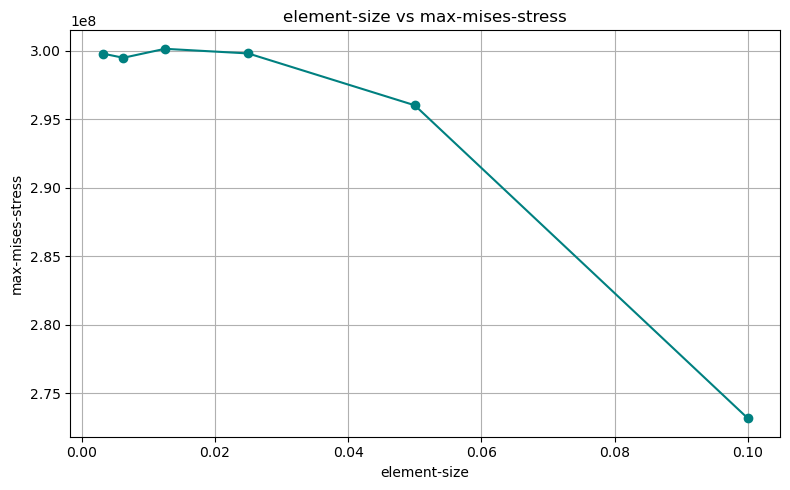

In [12]:
import matplotlib.pyplot as plt

x = [float(row[headers.index("element-size")]) for row in table_data]
y = [float(row[headers.index("max-mises-stress")]) for row in table_data]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, marker='o', linestyle='-', color='teal')
plt.xlabel("element-size")
plt.ylabel("max-mises-stress")
plt.title("element-size vs max-mises-stress")
plt.grid(True)
plt.tight_layout()
plt.show()